In [29]:
# import local package
# import sys
# sys.path.append('/Users/xxu35/Library/CloudStorage/GoogleDrive-xxu35@ncsu.edu/My Drive/_MachineLearning/GymNikki')
# print(sys.path)

import matplotlib.pyplot as plt
import numpy as np

from scipy.integrate import solve_ivp
from scipy.integrate import odeint

import scipy




In [30]:

import argparse
import gymnasium as gym
from stable_baselines3 import DDPG, TD3
# from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv
# from stable_baselines3.td3.policies import TD3Policy

# define env

balance_time = 40; h_in = 1/100;

# sys.path.append('/gdrive/My Drive/_MachineLearning/GEARS')
CartPoleSwingUp = gym.register(id='CartPoleSwingUp',
                             entry_point='myCartpoleF_SwingUp:CartPoleSwingUp',
                             # entry_point='gymnasium.envs.classic_control:myCartpoleF_SwingUp',
                             reward_threshold=0,
                             # max_episode_steps=int( balance_time / h_in ),
                               )
# env = gym.make('CartPoleSwingUp',render_mode='human')


# env = gym.make('CartPoleSwingUp', render_mode='rgb_array')
# Create a vectorized environment with rendering enabled
env = DummyVecEnv([lambda: gym.make('CartPoleSwingUp', render_mode='rgb_array')])

#load model and simulate controls
# Load the pre-trained model and assign the environment
# model = TD3.load('./model/td3_newReset', env=env)
# save_path='/gdrive/My Drive/_MachineLearning/GEARS/model/td3_nikki'
# load_path = './model/td3_smaller_force' # your model path
# load_path = '/gdrive/My Drive/_MachineLearning/GEARS//NCSU-GEARS-master/model/td3_smaller_force' # your model path
model = TD3.load(path='ddpg_cartpole_model.zip', env=env)
# model.load_replay_buffer(load_path + "/td3_swingup_balance_replay_buffer")

In [31]:
print(f"Model structure: {model.policy.net_arch}\n\n")

# model1 = TD3.load(path='/gdrive/My Drive/_MachineLearning/GEARS/NCSU-GEARS-master/model/td3' + '/td3_swingup_balance', env=env)
# print(model1.policy_kwargs)

"""
for name, param in model1.policy_kwargs:
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")
"""

Model structure: [256, 128]




'\nfor name, param in model1.policy_kwargs:\n    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")\n'

In [32]:
# model.get_parameters.state_dict

model_param = model.get_parameters()
model_policy = model_param['policy']
model_policy.keys()

W0 = np.array(model_policy['actor.mu.0.weight'])
b0 = np.array(model_policy['actor.mu.0.bias'])
W1 = np.array(model_policy['actor.mu.2.weight' ])
b1 = np.array(model_policy['actor.mu.2.bias'])
W2 = np.array(model_policy['actor.mu.4.weight' ])
b2 = np.array(model_policy['actor.mu.4.bias'])
#W3 = np.array(model_policy['actor.mu.6.weight'])
#b3 = np.array(model_policy['actor.mu.6.bias'])

# save paramters to txt file so that matlab can read them into matrices
for param_tensor in model_policy.keys():
    # find actor network
    if 'actor.mu.' in param_tensor:
      print(param_tensor + ':' + str(model_policy[param_tensor].shape) )
      # print(model_policy[param_tensor])
      load_path = 'C:\\Users\\ZPD\\Desktop\\GEARS'
      np.savetxt(load_path + '\\250130_td3txt'
                + param_tensor + '.txt',
                model_policy[param_tensor],
                delimiter=',')

      

actor.mu.0.weight:torch.Size([256, 5])
actor.mu.0.bias:torch.Size([256])
actor.mu.2.weight:torch.Size([128, 256])
actor.mu.2.bias:torch.Size([128])
actor.mu.4.weight:torch.Size([1, 128])
actor.mu.4.bias:torch.Size([1])


In [33]:
# Wb is a dict
Wb = {
    "W0": W0,
    "b0": b0,
    "W1": W1,
    "b1": b1,
    "W2": W2,
    "b2": b2,
    #"W3": W3,
    #"b3": b3
}

# for this proj - nn_Control has fixed shape, so to reduce computation, we fix the shapes
# otherwise, uncomment the size_0 and size_2 def? still will be slow
size_0 = Wb["W0"].shape
size_2 = Wb["W1"].shape
size_4 = Wb["W2"].shape
#size_6 = Wb["W3"].shape

print(size_0)

(256, 5)


In [34]:
# define nn control
def nn_Control(x, Wb):
    # Wb = (W0, b0, W1, b1, W2, b2, W3, b3)
    # size_0 = Wb["W1"].shape
    shared_net_0_activated = np.maximum(np.zeros_like(size_0[0],),
                                        Wb["W0"] @ x + Wb["b0"].flatten())
    # size_2 = Wb["W2"].shape
    shared_net_2_activated = np.maximum(np.zeros_like(size_2[0],),
                                      Wb["W1"] @ shared_net_0_activated + Wb["b1"].flatten())
    

    u = Wb["W2"] @ shared_net_2_activated + Wb["b2"].flatten()
    return 10 * np.tanh(u)



In [35]:
# initialize t, h, num_steps

# x0 = [0.1, - 0.1, -0.1 , 0.1 ]
seed = 1
# env = gym.make('NikkiCartPole')
env = env
# x0, info = env.reset(seed=seed) # dummyvecenv doesnt take seed as an arg
env = DummyVecEnv([lambda: gym.make('CartPoleSwingUp', render_mode='rgb_array')])
obs0 = env.reset()
# x0, x_dot0, cos0, sin0, theta_dot0 = obs0[0]
# reset obs = np.array( (np.sin(theta), np.cos(theta), theta_dot, x, x_dot), dtype=np.float32).flatten()
# step obs = np.array( (x, x_dot, np.cos(theta), np.sin(theta), theta_dot), dtype=np.float32).flatten()

x0, x_dot0, cos0, sin0, theta_dot0,  = obs0[0]
theta0 = np.arctan2(sin0, cos0)
h_in = .01 #This is the step size.
x_in = np.array((x0, x_dot0, theta0, theta_dot0), dtype=np.float32).flatten()
t0 = 0; tf = 40;

# t0 = 0; tf = balance_time;

num_steps = int(np.ceil(tf/h_in)) #The np.ceil is defensive coding: what if h doesn't divide [0,5] evenly

t = np.linspace(t0,tf,num_steps+1) #create a vector of time t_i

h_in = tf/num_steps #This updates h to account for the possibility that it changed due to np.ceil.

# set parameter values (gravity, masscart, masspole, length, r_mp, Jm, Kg, Rm, Beq, Bp, Kt, Km = p )
# from Emi's thesis
gravity = 9.81 # N/kg
masscart = 0.57+0.37 # kg
masspole = 0.230 # kg
length = 0.3302 # m
r_mp = 6.35e-3 # motor pinion radius (m)
Jm = 3.90e-7 # rotor moment of inertia
Kg = 3.71 # planetary gearbox gear ratio
Rm = 2.6 # motor armature resistance (Ohm)
Beq = 5.4 #  equivalent viscous damping coecient as seen at the motor pinion
Bp = 0.0024 # viscous damping doecient, as seen at the pendulum axis
Kt = 0.00767 # motor torque constant
Km = 0.00767 # Back-ElectroMotive-Force (EMF) Constant V.s/RAD

# a dict of system parameters
p_system = {
    "gravity": gravity,
    "masscart": masscart,
    "masspole": masspole,
    "length": length,
    "r_mp": r_mp,
    "Jm": Jm,
    "Kg": Kg,
    "Rm": Rm,
    "Beq": Beq,
    "Bp": Bp,
    "Kt": Kt,
    "Km": Km
    } # all parameters in the original ode

name_of_vars = ['x', 'x_dot', 'theta', 'theta_dot']

now Reset


In [36]:
# Define two models for the dynamical system

def CartPolePhysics(t, z, p, Vm):
    position, velocity, angle, angular_velocity = z
    # np.array(list(dict.values())) create an array of values of the list
    if type(p) == dict:
      gravity, masscart, masspole, length, r_mp, Jm, Kg, Rm, Beq, Bp, Kt, Km = np.array(list(p.values()))

    if type(p) == np.ndarray:
      gravity, masscart, masspole, length, r_mp, Jm, Kg, Rm, Beq, Bp, Kt, Km = p

    total_mass = masspole + masscart
    costheta = np.cos(angle)
    sintheta = np.sin(angle)


    d = 4 * masscart * r_mp**2 + masspole * r_mp**2 + 4 * Jm * Kg**2 + 3 * r_mp**2 * masspole * sintheta**2

    a33 = -4 * ( Rm * r_mp**2 * Beq + Kg**2 * Kt * Km
              ) / (
                Rm * d
              )

    a34 = - ( 3 * r_mp**2 * Bp * costheta + 4 * masspole * length**2 * r_mp**2 * sintheta * angular_velocity
            ) / (
                length * d
            )

    a43 = -3 * ( Rm * r_mp**2 * Beq + Kg**2 * Kt * Km
            ) * costheta / (
                Rm * length * d
            )

    a44 = -3 * (
                    ( total_mass * r_mp**2 + Jm * Kg**2) * Bp +
                    ( masspole**2 * length**2 * r_mp**2 * costheta * sintheta * angular_velocity )
                ) / (
                    masspole * length**2 * d
                )


    # extra forces on velocity term (Emi's thesis eq 3.2 second plus term)
    aa3 = ( 3 * masspole * r_mp**2 * gravity * costheta * sintheta
            ) / (
            d
            )

    aa4 = ( 3 * (
                    total_mass * r_mp**2 + Jm * Kg**2
                ) * gravity * sintheta
            ) / (
            length * d
            )

    # controller
    b3 = (4 * r_mp * Kg * Kt) / (Rm * d)

    b4 = (3 * r_mp * Kg * Kt * costheta) / (length * Rm * d)

    dxdt = [ velocity + 0 * Vm,
             a33 * velocity + a34 * angular_velocity + aa3 + b3 * Vm,
             angular_velocity + 0 * Vm,
             a43 * velocity + a44 * angular_velocity + aa4 + b4 * Vm
           ] # + ( 0, 0, b3*0, b4*0) # b3 and b4 should be multiplied by u = Vm (cart's motor)

    return np.array(dxdt, dtype=np.float32).flatten()



In [37]:
# define a function to solve the ivp problem that takes different dynamical system and weight/bias matrices from nn

def sol_ivp_withControl(dyn_sys, p, x0, h, Wb):
    """
    Description:
    dyn_sys: dynamical system to be solved by solve_ivp
    p: parameters within the dynamical system
    x0: inital condition - must be state variable
    h: step size
    Wb: neural network control weights and biases as a dict
    """
    # t = np.linspace(t0,tf,int(np.ceil(tf/h))+1)
    z = np.zeros((t.shape[0],4)) # state var
    Vm = np.zeros((t.shape[0],1)) # control var
    z[0,:] = x0
    # Vm[0] = nn_Control_withParam(x = x0, Wb = Wb)
    position0, velocity0, angle0, angular_velocity0 = x0
    nn_input0 = np.array((position0, velocity0, np.cos(angle0), np.sin(angle0), angular_velocity0), dtype=np.float32) # control input obs ((x, x_dot, np.cos(theta), np.sin(theta), theta_dot))
    Vm[0] = nn_Control(x = nn_input0, Wb = Wb)

    for i in range(num_steps):
        # span for next time step
        tspan = [t[i],t[i+1]]

        # solve for next step
        sol = solve_ivp(fun = dyn_sys,
                        t_span = tspan,
                        y0 = z[i,:],
                        args=(p, Vm[i],),
                        t_eval=tspan,
                        dense_output=True)
        # y[i+1, :] = odeint(CartPolePhysics, y[i,:], tspan, args=(Vm[i],))[1]
        z[i+1, :] = sol.y[:,-1]
        # Vm[i+1] = nn_Control_withParam(x = z[i+1,:], Wb = Wb)
        position, velocity, angle, angular_velocity = z[i+1, :]
        nn_input = np.array((position, velocity, np.cos(angle), np.sin(angle), angular_velocity), dtype=np.float32) # control input obs ((x, x_dot, np.cos(theta), np.sin(theta), theta_dot))
        Vm[i+1] = nn_Control(x = nn_input, Wb = Wb)

    return (t, z)


In [38]:
## this block uses RK4 to integrate the system
def RK4_withCtrl(rhs, x0, h, tspan, p, Wb):
    """
    input:
      rhs: the RHS of the ODE governing the state variable
      x0: initial condition
      h: step size
      tspan: time span
      p: system parameters
      Vm: Control_nn(x, Wb)

    output:
      z: state, dim(tspan) x 4
      Vm: control input, dim(tspan) x 1
    """
    t = tspan
    z = np.zeros((t.shape[0],4))
    Vm = np.zeros((t.shape[0],1))

    z[0,:] = x0
    position, velocity, angle, angular_velocity = x0
    nn_input = np.array((position, velocity, np.cos(angle), np.sin(angle), angular_velocity), dtype=np.float32) # control input obs ((x, x_dot, np.cos(theta), np.sin(theta), theta_dot))
    Vm[0] = nn_Control(x = nn_input, Wb = Wb)


    #For loop implementation
    for i in range(num_steps):
        k1 = rhs(t = t[i], z=z[i,:], Vm = Vm[i,:], p = p)
        k2 = rhs(t = t[i] + h / 2, z=z[i,:] + h * k1 / 2, Vm=Vm[i,:], p = p)
        k3 = rhs(t = t[i] + h / 2, z=z[i,:] + h * k2 / 2, Vm=Vm[i,:], p = p)
        k4 = rhs(t = t[i] + h, z=z[i,:] + h * k3, Vm=Vm[i,:], p = p)

        z[i+1,:] = z[i,:] + h/6 * (k1 + 2 * k2 + 2 * k3 + k4)
        # Vm[i+1] = nn_Control(x=z[i+1,:], Wb = Wb )
        position, velocity, angle, angular_velocity = z[i+1, :]
        nn_input = np.array((position, velocity, np.cos(angle), np.sin(angle), angular_velocity), dtype=np.float32) # control input obs ((x, x_dot, np.cos(theta), np.sin(theta), theta_dot))
        Vm[i+1] = nn_Control(x = nn_input, Wb = Wb)


    return z, Vm

## this block uses RK4 to integrate the system
def RK4_withoutCtrl(rhs, x0, h, tspan, p, Wb):
    """
    input:
      rhs: the RHS of the ODE governing the state variable
      x0: initial condition
      h: step size
      tspan: time span
      p: system parameters
      Vm: Control_nn(x, Wb)
    """
    t = tspan
    z = np.zeros((t.shape[0],4))
    Vm = np.zeros((t.shape[0],1))

    z[0,:] = x0
    # Vm[0] = nn_Control(x = x0, Wb = Wb)

    #For loop implementation
    for i in range(num_steps):
        k1 = rhs(t = t[i], z=z[i,:], Vm = Vm[i,:], p = p)
        k2 = rhs(t = t[i] + h / 2, z=z[i,:] + h * k1 / 2, Vm=Vm[i,:], p = p)
        k3 = rhs(t = t[i] + h / 2, z=z[i,:] + h * k2 / 2, Vm=Vm[i,:], p = p)
        k4 = rhs(t = t[i] + h, z=z[i,:] + h * k3, Vm=Vm[i,:], p = p)

        z[i+1,:] = z[i,:] + h/6 * (k1 + 2 * k2 + 2 * k3 + k4)
        # Vm[i+1] = nn_Control(x=z[i+1,:], Wb = Wb )

    return z


In [39]:
# Vm = 0 # RHS parameter - control u = Vm (voltage of motor on cart)
# simulate without control
x_in = np.array((0.1, 0.1, -0.1, -0.1), dtype = np.float32).flatten()
nonlin_noCtrl = solve_ivp(fun = CartPolePhysics,
                          t_span=[t0, tf],
                          y0 = x_in,
                          t_eval = t,
                          args=(p_system, 0,))

nonlin_noCtrl_RK4 = RK4_withoutCtrl(rhs = CartPolePhysics,
                                    x0 = x_in,
                                    h=h_in,
                                    tspan=t,
                                    p = p_system,
                                    Wb = Wb)

# compute sum of differences using two solvers
mse_CartPolePhysics = np.square(nonlin_noCtrl.y.T - nonlin_noCtrl_RK4).mean()
print('Mean Square Error between Solvers for CartPolePhysics is ', mse_CartPolePhysics)


Mean Square Error between Solvers for CartPolePhysics is  2.227627487025543e-06


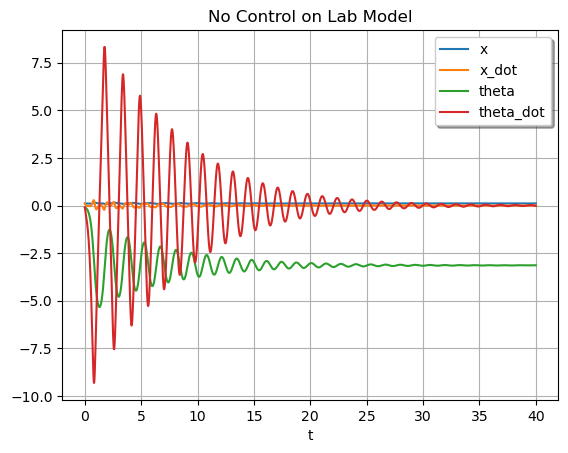

In [40]:
plt.plot(t, nonlin_noCtrl.y.T) # plot the transpose from odeint solve
plt.xlabel('t')
plt.legend(name_of_vars, shadow=True)
plt.title('No Control on Lab Model')
plt.grid()
# plt.ylim((-0.25, 0.5))
plt.show()


now Reset
Mean Square Error between Solvers for nn Controlled CartPolePhysics is  0.5089789840105771


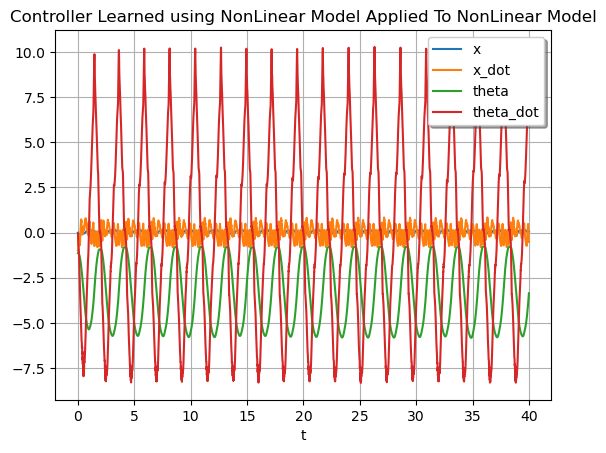

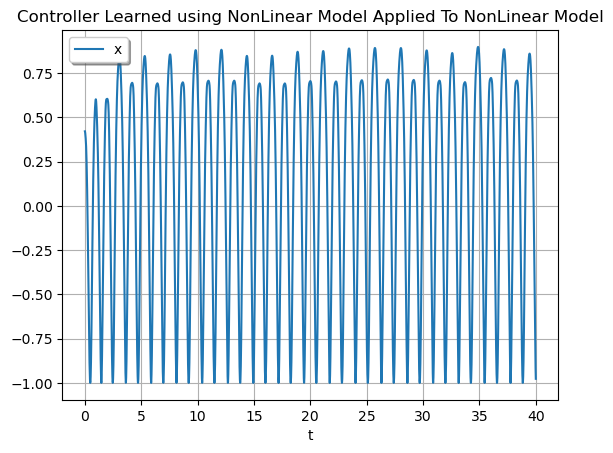

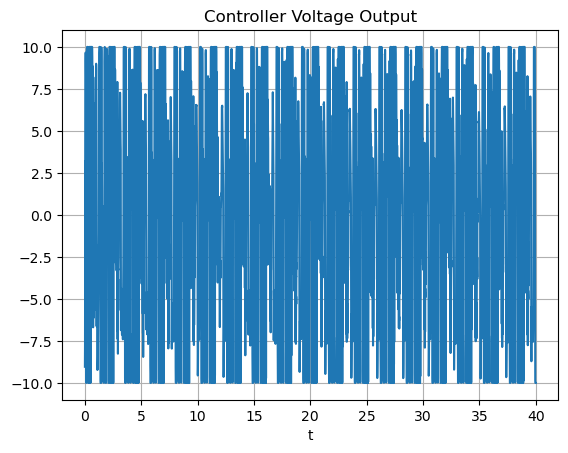

In [41]:
obs0 = env.reset()
# x0, x_dot0, cos0, sin0, theta_dot0 = obs0[0]
# reset obs = np.array( (np.sin(theta), np.cos(theta), theta_dot, x, x_dot), dtype=np.float32).flatten()
# step obs = np.array( (x, x_dot, np.cos(theta), np.sin(theta), theta_dot), dtype=np.float32).flatten()

x0, x_dot0, cos0, sin0, theta_dot0,  = obs0[0]
theta0 = np.arctan2(sin0, cos0)
h_in = .01 #This is the step size.
x_in = np.array((x0, x_dot0, theta0, theta_dot0), dtype=np.float32).flatten()

(t,nn_controlled_sesip_odeint) = sol_ivp_withControl(dyn_sys=CartPolePhysics , p = p_system, x0 = x_in, h = h_in, Wb=Wb)
(nn_controlled_sesip_RK4, voltages) = RK4_withCtrl(rhs=CartPolePhysics,
                                                    x0=x_in,
                                                    h = h_in,
                                                    tspan=t,
                                                    p=p_system,
                                                    Wb=Wb)

mse_controls = np.square(nn_controlled_sesip_odeint - nn_controlled_sesip_RK4).mean()
print('Mean Square Error between Solvers for nn Controlled CartPolePhysics is ', mse_controls)


plt.plot(t, nn_controlled_sesip_RK4)
plt.xlabel('t')
plt.legend(name_of_vars, shadow=True)
plt.title('Controller Learned using NonLinear Model Applied To NonLinear Model')
plt.grid()
# plt.ylim((-0.25, 0.5))
plt.show()


plt.plot(t, np.cos(nn_controlled_sesip_RK4[:, 2]))
plt.xlabel('t')
plt.legend(name_of_vars, shadow=True)
plt.title('Controller Learned using NonLinear Model Applied To NonLinear Model')
plt.grid()
# plt.ylim((-0.25, 0.5))
plt.show()

plt.plot(t, voltages)
plt.xlabel('t')
# plt.legend(name_of_vars, shadow=True)
plt.title('Controller Voltage Output')
plt.grid()
# plt.ylim((-0.25, 0.5))
plt.show()